In [63]:
import fenics

import numpy as np
import chaospy as cpy
import matplotlib.pyplot as plt
import seaborn as sns

from chaospy import Uniform
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process.kernels import RBF
from scipy.special import logit

from source.models.gaussian_processes import GPSurrogate
from source.models.high_fidelity import HighFidelityModel
from source.models.chaos_expansion import PCESurrogate
from source.problems.hyperelastic.damaged_beam import DamagedBeam
from source.distributions.cond_inv_gamma import CondInvGamma
from source.distributions.gauss_distr import GaussDensity, IndComponentsGaussian
from source.distributions.uniform_distr import UnifDistr
from source.utils.diagnostics import run_and_track, diagnostics_report, visual_inspection, show_or_save
from source.utils.diagnostics import surface_plot, wireframe_plot, points_plot, box3d_plot

In [64]:
fenics.set_log_level(30)
np.random.seed(1226)
sns.set_style('whitegrid')

In [65]:
# problem parameters
dim = 2
num_data = 75                                   # sample's dimension of data collected
noise_sigma = .0025                             # since we generate the data we add some artificial noise
param_true_z = np.array([.25, .1])
true_z = logit(param_true_z)

In [66]:
# distribution parameters
def inv_logit(x_):
    return 1./(1. + np.exp(-x_))
param_remapper = [inv_logit, inv_logit]
prior_means = np.array([-1., -2.])
prior_sigmas = np.array([2., 2.])
proposal_sigma = 1.e-1     #np.array([1.e-2, 5.5e-3])  we set up a RW chain on z[0] and an independent chain on z[1]
inv_gamma_parameters = np.array([3., 2.])

In [67]:
# MCMC parameters
samples = 10000
subchain_len = 1000
upper_th = 1e-4
error_th = 1e-2
init_z = prior_means
init_variance = .05
init_radius = .45
rho = .7
burn = 4000

In [68]:
# surrogate parameters
use_gpr = True
run_high_fidelity = False
quad_points = 50
multi_fidelity_q = 20

In [69]:
# definition of the forward model for data generation - finer grid to avoid inverse crimes
eval_times = np.arange(.1, 1., .1)
lx, ly, lz = 1., .1, .1
data_gen_forward_model = DamagedBeam(
    eval_times=eval_times, lx=lx, ly=ly, lz=lz,
    log_transform=False, param_remapper=param_remapper, time=1.25)

In [70]:
# forward model for the MCMCs
forward_model = DamagedBeam(
    eval_times=eval_times, lx=lx, ly=ly, lz=lz,
    log_transform=False, param_remapper=param_remapper, n=5, timestep=.3, time=1.25)


In [71]:
# generation of the dataset
x = np.concatenate([
    lx * np.random.uniform(0., 1., size=(1, num_data)),
    ly * np.random.uniform(0., 1., size=(1, num_data)),
    lz * np.random.uniform(0., 1., size=(1, num_data))])
orig_data, last_sol = data_gen_forward_model(true_z, x, reshape=False, retall=True)
_, proxy_solution = forward_model(true_z, x, reshape=False, retall=True)
true_data = orig_data.flatten()
orig_noise = np.random.normal(0, noise_sigma, size=orig_data.shape)
noise = orig_noise.flatten()
data = true_data + noise


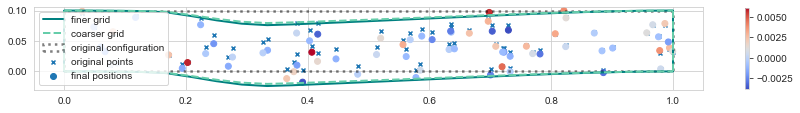

In [72]:
# show reference points and their position in the deformed configuration
fig, ax = plt.subplots(figsize=(15, 3))
plt.scatter(x=x[0, :], y=x[2, :], marker='x', s=16, label='original points')
scatter = plt.scatter(
    x=x[0, :], y=x[2, :] + orig_data[:, -1] + orig_noise[:, -1], c=orig_noise[:, -1],
    cmap='coolwarm', label='final positions')
fig.colorbar(scatter, shrink=.5)

# compute the profile of the beam's central section
disp_x = np.linspace(0., lx, 25)
sup_profile = np.array([lz + last_sol((x_, lz, ly / 2))[2] for x_ in disp_x])
inf_profile = np.array([last_sol((x_, 0., ly / 2))[2] for x_ in disp_x])
proxy_sup_profile = np.array([lz + proxy_solution((x_, lz, ly / 2))[2] for x_ in disp_x])
proxy_inf_profile = np.array([proxy_solution((x_, 0., ly / 2))[2] for x_ in disp_x])

# showing original and deformed configuration
def plot_deformed(superior, inferior, xcoords, xlen, zlen, label=None, **style_params):
    plt.plot(xcoords, superior, label=label, **style_params)
    plt.plot(xcoords, inferior, **style_params)
    plt.plot((0., 0.), (0., zlen), **style_params)
    plt.plot((xlen, xlen), (0., zlen), **style_params)

plot_deformed(
    sup_profile, inf_profile, disp_x, lx, lz,
    color='teal', linewidth=2, label='finer grid')
plot_deformed(
    proxy_sup_profile, proxy_inf_profile, disp_x, lx, lz,
    color='mediumaquamarine', linestyle='--', linewidth=2, label='coarser grid')
rect = Rectangle(
    (0, 0), width=lx, height=lz, color='black', linestyle=':', linewidth=2.5,
    alpha=.5, fill=False, label='original configuration')
ax.add_patch(rect)
ax.legend()
ax.set_aspect('equal')
show_or_save('deformation', save=False)

In [73]:
# useful distributions and densities
def log_prior(z_):
    return -np.sum((z_ - prior_means) ** 2 / (2 * prior_sigmas ** 2))

prior = cpy.J(*[cpy.Normal(m, s) for m, s in zip(prior_means, prior_sigmas)])
log_err_density = GaussDensity(.1)
proposal = GaussDensity(proposal_sigma)
full_cnd_sigma2 = CondInvGamma(*inv_gamma_parameters)

In [74]:
# models
hfm = HighFidelityModel(
    forward_model, data, x, log_err_density, log_prior)
lfm = PCESurrogate(data, log_err_density, prior, log_prior, 5, multi_fidelity_q)
gps = GPSurrogate(
    data, log_err_density, prior, log_prior, RBF(2.), multi_fidelity_q, n_restarts_optimizer=5, alpha=1e-2)

if use_gpr:
    low_fi_models = [lfm, gps]
    surrogate_types = ['PCE', 'GPR']
else:
    low_fi_models = [lfm]
    surrogate_types = ['PCE']
method_names = (['true model (MH)'] if run_high_fidelity else [])+ \
    ['{} surrogate (MH)'.format(typ) for typ in surrogate_types] + \
    ['{} surr. (adap. MH)'.format(typ) for typ in surrogate_types]

In [ ]:
# running MCMCs
fit_times, fit_calls, exec_times, exec_calls, mh_samples = run_and_track(
    hfm, low_fi_models, quad_points, proposal, full_cnd_sigma2, init_z, init_variance,
    samples, subchain_len, upper_th, error_th, init_radius, rho,
    remap_functions=[inv_logit, inv_logit], run_high_fidelity=run_high_fidelity)

fit	 41% |============                 | ETA:   0:00:27 - Elapsed Time: 0:00:24

In [ ]:
# displaying results
diagnostics_report(
    method_names, exec_times, exec_calls, fit_times, fit_calls,
    len(low_fi_models), samples, burn, mh_samples, first_is_high_fidelity=run_high_fidelity)

In [ ]:
visual_inspection(dim, method_names, mh_samples, samples, burn, save=False)
